# Train donkeycar with GPU support in Colab
> Use Colab to train a neural network for a donkey car 

- toc: true
- badges: true
- categories: [donkeycar, Colab]
- image: images/roboCar2020.jpg
- author: Uwe Sterr
- comments: true

# Credit
> Note: This notebook is based on https://colab.research.google.com/github/robocarstore/donkey-car-training-on-google-colab/blob/master/Donkey_Car_Training_using_Google_Colab.ipynb

Get necessary libraries

In [19]:
#collapse-hide
%tensorflow_version 1.13.1
import tensorflow
from google.colab import drive
from google.colab import files
from IPython.display import Image
import glob
import shutil 

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13.1`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


# Step 1: Create environment
To train a neural network for the donkeycar we need a few components
- install donkeycar
- upload data via  
    - direct upload
    - mount Google drive

## Check GPU allocation
If "Found GPU at: / device: GPU: 0" is displayed, the GPU is ready to use.

> Note: Donkeycar at the time of writing in March 2020 uses Tensorflow 1.13, therefore version 1.xx is installed

In [1]:
#collapse-show 

print(tensorflow.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13.1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0


## Git Clone the donkeycar repository

Get the latest donkeycar version from GitHub 
> Note: The default branch is "dev", however, the documentation is for the master branch.

In [2]:
!git clone https://github.com/autorope/donkeycar.git 
%cd /content/donkeycar

!git checkout master

Cloning into 'donkeycar'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 12180 (delta 119), reused 162 (delta 60), pack-reused 11948
Receiving objects: 100% (12180/12180), 65.21 MiB | 19.92 MiB/s, done.
Resolving deltas: 100% (7621/7621), done.
/content/donkeycar
Branch 'master' set up to track remote branch 'master' from 'origin'.
Switched to a new branch 'master'


## Install donkey car
Different to the description at http://docs.donkeycar.com/guide/host_pc/setup_ubuntu/ we create no anaconda environment since the script is supposed to run on Colab which will delete the instance anyway once you disconnect the notebook.

In [3]:
!pip3 install -e .[pc]

Obtaining file:///content/donkeycar
     |████████████████████████████████| 102kB 4.9MB/s 
  Created wheel for paho-mqtt: filename=paho_mqtt-1.5.0-cp36-none-any.whl size=61416 sha256=7f50315883bda4885cd47da68ae05b9a27f25915bfca823b3bd155bdaa8c42ea
  Stored in directory: /root/.cache/pip/wheels/02/94/6c/8474137cb7a5a3e001d70a22c8ff919caee69435376bccce79
Successfully built paho-mqtt
  Running setup.py develop for donkeycar


## Create Project
In this step the following actions take place
- create necessary folders (models, data, logs)
- copying necessary files into folders (manage.py, myconfig.py etc.)


In [4]:
!donkey createcar --path /content/mycar

using donkey v3.1.1 ...
Creating car folder: /content/mycar
making dir  /content/mycar
Creating data & model folders.
making dir  /content/mycar/models
making dir  /content/mycar/data
making dir  /content/mycar/logs
Copying car application template: complete
Copying car config defaults. Adjust these before starting your car.
Copying train script. Adjust these before starting your car.
Copying my car config overrides
Donkey setup complete.


# Step 2: Supply Data
In order to train the neural network we need to supply trainings data which are recorded on the raspi during driving the donkeycar on the track



## Step 2 opt A: Supply own data
If you have own data proceed here, if you want to use data which were made available via GitHub please continue to (link only works in blog not in Colab) [section](#GitHubData) **Supply GitHub hosted data**



### Zip data on raspi 
Copy the following code and run on raspi 
> Note: Copying of the data is much faster if the data is zipped to one file.

```bash
cd ~/mycar/data
# either compress just one folder
tar -czf tub_xx_yyyy_mm_dd.tar.gz tub_xx_yyyy_mm_dd
# or all folders starting with "tub"
tar -czf trainingsData2020_03-01.tar.gz tub*


```

This will create a tub_xx_yyyy_mm_dd.tar.gz file under ~/mycar/data

### Copy the zipped tub to your local PC

Run this on your local pc if you are using linux/mac
```
sftp pi@raspberry.local
cd ~/mycar/data
get tub_xx_yyyy_mm_dd.tar.gz
```

If you are on a windows, download sftp utility like [filezilla](https://filezilla-project.org/) or [putty](https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html)

Define your tub name here

In [0]:
tub_name="tubVaihingenIIICleaned200126"

### Upload the tub from Google Drive

First upload the tub_x_yyyy_mm_dd.tar.gz to Google Drive. We will then mount Google Drive from colab and copy the data from Drive directly. 
> Note: To copy data from Google Drive to Colab is faster than uploading it from local machine.  

When you run the cell below, you will need to click the link and generate an authorization code to for colab to access your drive.

In [0]:
drive.mount('/content/drive')

Suppose you upload the tub_xx_yyyy_mm_dd.tar.gz to Google Drive/mycar/tub_xx_yyyy_mm_dd.tar.gz, this is how you copy it from Google Drive to colab

In [21]:
%cd /content/mycar
!rm -rf data
!mkdir data
%cd /content/mycar/data
!cp /content/drive/My\ Drive/myCar/{tub_name}.tar.gz .

/content/mycar
/content/mycar/data


And untar it to the right place

In [22]:
%cd /content/mycar/data
!tar -xzf {tub_name}.tar.gz

/content/mycar/data


Lets look at one image to see we got valid data

/content/mycar/data/tubVaihingenIIICleaned200126


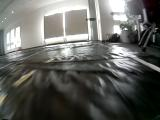

In [23]:
%cd /content/mycar/data/tubVaihingenIIICleaned200126/
file = glob.glob("*.jpg")
Image(file[100])

### Check quality of data
You want data which has left and right turns preferably in equal shares. A histogram is a good tool to check if this is the case. You can use a donkeycar tool for that


```
donkey tubhist <tub_path> --rec=<"user/angle">
```
The histogram shows that mainly the car drove straight ahead and more left turns than right turns. It is good practice to drive a course clock wise and anti clock wise to avoid this imbalance.


/content/mycar
using donkey v3.1.1 ...
TubGroup:tubpaths: ['/content/mycar/data/tubVaihingenIIICleaned200126']
joining the tubs 14234 records together. This could take 0 minutes.
saving image to: tubVaihingenIIICleaned200126_hist_user_angle.png
<Figure size 640x480 with 1 Axes>


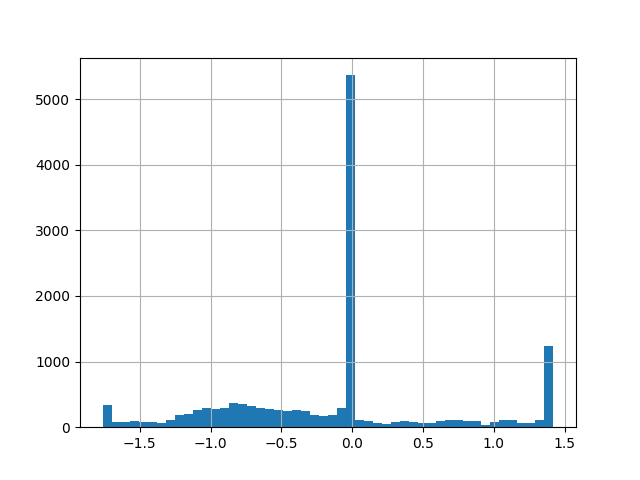

In [0]:
%cd /content/mycar
!donkey tubhist --tub data/{tub_name} --rec="user/angle"
file = glob.glob("tubVaihingenIIICleaned200126_hist_user_angle.png")
Image(file[0])

Next step is to train your model in section [Upload local files](#uplaod_local_files) (Link only works in blog not in Colab)

## Supply GitHub hosted data
<a id='GitHubData'></a>
If you don't have own training data you might want to use an example data set

> Note: The training data is cleaned ([tubclean](https://docs.donkeycar.com/utility/donkey/#clean-data-in-tub)) but whether or not you get a good working model out of it...  

See instructions below how to get the data into the Colab environment



The training data are **hosted on GitHub**
- clone GitHub repo
- move file to data folder
- unzip file

## Step 2 opt B: Use data from RoboCarEsslingen
The first data set we use is from [RoboCar Esslingen GitHub
](https://github.com/RoboCarEsslingen) which is operated by the meetup group [Esslinger Makerspace Projekt: Autonomen RoboCar bauen](https://www.meetup.com/Esslingen-Makerspace/) located in Esslingen, Germany.  
The data was recorded at [#8.7 Quarterly Hack: DIYrobocars Build & Race](https://www.meetup.com/Connected-Autonomous-Driving/events/259840582/) in Suttgart with kind support of Bosch.  
If you want to use data from **Connected Atonomous Mobility** proceed in chapter (link only works in blog not in Colab) [section](#CamData) **Use data from Connected Autonomous Mobility**

In [14]:
%cd /content/mycar
!rm -rf data
!mkdir data
%cd /content/mycar/data
!pwd
! git clone --recursive https://github.com/RoboCarEsslingen/trainingData.git


/content/mycar
/content/mycar/data
/content/mycar/data
Cloning into 'trainingData'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


Move zip file to data folder and unzip


In [15]:
shutil.move("/content/mycar/data/trainingData/tubVaihingenIIICleaned200126.tar.gz", "/content/mycar/data") 

'/content/mycar/data/tubVaihingenIIICleaned200126.tar.gz'

Unzip the training data file


In [7]:
%cd /content/mycar/data
!tar -xzf tubVaihingenIIICleaned200126.tar.gz

/content/mycar/data


#### Check quality of data
You want data which has left and right turns preferably in equal shares. A histogram is a good tool to check if this is the case. You can use a donkeycar tool for that


```
donkey tubhist <tub_path> --rec=<"user/angle">
```
The histogram shows that mainly the car drove straight ahead and more left turns than right turns. It is good practice to drive a course clock wise and anti clock wise to avoid this imbalance.


/content/mycar
using donkey v3.1.1 ...
TubGroup:tubpaths: ['/content/mycar/data/tubVaihingenIIICleaned200126']
joining the tubs 14234 records together. This could take 0 minutes.
saving image to: tubVaihingenIIICleaned200126_hist_user_angle.png
<Figure size 640x480 with 1 Axes>


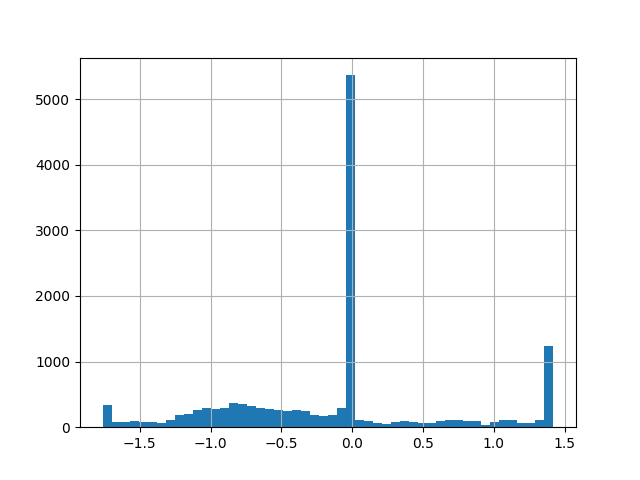

In [0]:
%cd /content/mycar
!donkey tubhist --tub data/{tub_name} --rec="user/angle"
file = glob.glob("tubVaihingenIIICleaned200126_hist_user_angle.png")
Image(file[0])

## Use data from Connected Autonomous Mobility
<a id='CamData'></a>
Another data set is from  [Connected Autonomous Mobility
](https://github.com/connected-autonomous-mobility/20-data)
We clone the whole repo because I don't know how to download a single file from a GitHub repo, **if you know how to this than please leave a note the comment section.**

In [9]:
%cd /content/mycar
!rm -rf data
!mkdir data
%cd /content/mycar/data
!pwd
! git clone --recursive https://github.com/connected-autonomous-mobility/20-data


/content/mycar
/content/mycar/data
/content/mycar/data
Cloning into '20-data'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 80 (delta 8), reused 0 (delta 0), pack-reused 61
Unpacking objects: 100% (80/80), done.


Move zip file to data folder and unzip


In [10]:
import shutil 
shutil.move("/content/mycar/data/20-data/20190414-BOSCH-Solaris-Course/tub_36_19-04-13.zip", "/content/mycar/data") 



'/content/mycar/data/tub_36_19-04-13.zip'

Unzip the training data file


In [11]:
%cd /content/mycar/data
!unzip tub_36_19-04-13.zip

Streaming output truncated to the last 5000 lines.
  inflating: tub_36_19-04-13/552_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5584_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5622_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5639_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5684_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5709_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5723_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5748_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5757_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5769_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/581_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5828_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5836_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5850_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5855_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5858_cam-image_array_.jpg  
  inflating: tub_36_19-04-13/5894_cam-i

Lets look at one image to get an impression what the car saw.

```
# This is formatted as code
```



/content/mycar/data/tub_36_19-04-13


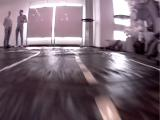

In [13]:
%cd /content/mycar/data/tub_36_19-04-13/
file = glob.glob("*.jpg")
Image(file[300])

#### Check quality of data
You want data which has left and right turns preferably in equal shares. A histogram is a good tool to check if this is the case. You can use a donkeycar tool for that


```
donkey tubhist <tub_path> --rec=<"user/angle">
```
The histogram shows that mainly the car drove straight ahead, left and right turns are pretty well balanced


/content/mycar
using donkey v3.1.1 ...
TubGroup:tubpaths: ['/content/mycar/data/tub_36_19-04-13']
joining the tubs 9136 records together. This could take 0 minutes.
saving image to: tub_36_19-04-13_hist_user_angle.png
<Figure size 640x480 with 1 Axes>


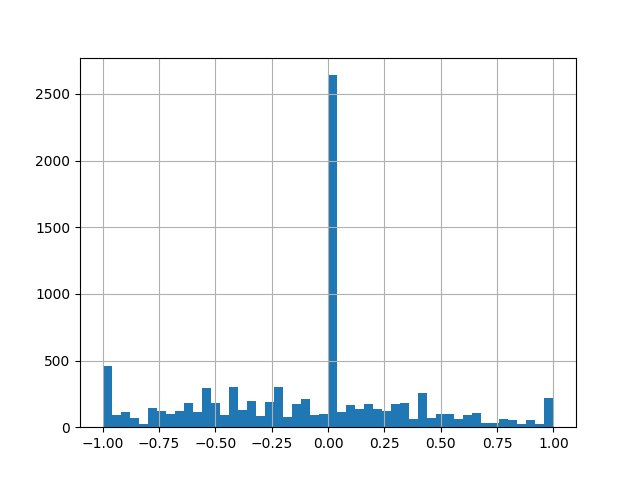

In [0]:
tub_name="tub_36_19-04-13"
%cd /content/mycar
!donkey tubhist --tub data/{tub_name} --rec="user/angle"
file = glob.glob("tub_36_19-04-13_hist_user_angle.png")
Image(file[0])

# Step 3: Upload local files
<a id='uplaod_local_files'></a>
You can upload files from local machine as well, but probably is slower than above approach downloading files from Google Drive

In [0]:
# uploaded = files.upload()



#### Get myconfig.py
The file `myconfig.py` has to be the identical during training and driving, therefore it makes sense to upload the `myconfig.py` which you are using on the car.

> Note: In `myconfig.py` there are parameters which control the training such as: 
 

```

 line parameter --type to the python manage.py train and drive commands.

 DEFAULT_MODEL_TYPE = 'linear'   (linear|categorical|rnn|imu|behavior|3d|localizer|latent)

 BATCH_SIZE = 128                how many records to use when doing one pass of gradient decent. Use a smaller number if your gpu is running out of memory.

 TRAIN_TEST_SPLIT = 0.8          what percent of records to use for training. the remaining used for validation.

 MAX_EPOCHS = 100                how many times to visit all records of your data

 SHOW_PLOT = True                would you like to see a pop up display of final loss?

 VEBOSE_TRAIN = True             would you like to see a progress bar with text during training?

 USE_EARLY_STOP = True           would you like to stop the training if we see it's not improving fit?

 EARLY_STOP_PATIENCE = 5         how many epochs to wait before no improvement

 MIN_DELTA = .0005               early stop will want this much loss change before calling it improved.

 PRINT_MODEL_SUMMARY = True      print layers and weights to stdout

 OPTIMIZER = None                adam, sgd, rmsprop, etc.. None accepts default

 LEARNING_RATE = 0.001           only used when OPTIMIZER specified

 LEARNING_RATE_DECAY = 0.0       only used when OPTIMIZER specified

 SEND_BEST_MODEL_TO_PI = False   change to true to automatically send best model during training

 CACHE_IMAGES = True             keep images in memory. will speed successive epochs, but crater if not enough mem.

 

 PRUNE_CNN = False               This will remove weights from your model. The primary goal is to increase performance.

 PRUNE_PERCENT_TARGET = 75        The desired percentage of pruning.

 PRUNE_PERCENT_PER_ITERATION = 20  Percentage of pruning that is perform per iteration.

 PRUNE_VAL_LOSS_DEGRADATION_LIMIT = 0.2  The max amount of validation loss that is permitted during pruning.

 PRUNE_EVAL_PERCENT_OF_DATASET = .05   percent of dataset used to perform evaluation of model.
RNN or 3D  
SEQUENCE_LENGTH = 3             #some models use a number of images over time. This controls how many.  

# # Region of interest cropping
# # only supported in Categorical and Linear models.
ROI_CROP_TOP = 0                    #the number of rows of pixels to ignore on the top of the image  
 ROI_CROP_BOTTOM = 0            #the number of rows of pixels to ignore on the bottom of the image 
```


 



In [0]:
%cd /content/mycar
!cp /content/drive/My\ Drive/myCar/myconfig.py .

/content/mycar


# Step 4: Train your model
<a id='train_model'></a>
There are several types of modes available:

 - linear
 - categorical
 - rnn
 - imu
 - behavior
 - 3d
 - localizer  
 And you can use pre-trained models by adding a flag
- `[--transfer=<model>]`

## Step 4 opt A: Transfer training of model
> Note: You can use a pre-trained model and use transfer learning

Do not forget to set the variables in myconfig.py  


```
FREEZE_LAYERS = True  
`#default False will allow all layers to be modified by training

NUM_LAST_LAYERS_TO_TRAIN = 7  
`#when freezing layers, how many layers from the last should be allowed to train?
```





#### Upload pre-trained model
Upload model in case you want to use a pre-trained model for transfer learning.
To define which layers shall be trained and which shall be frozen set the parameters in `myconfig.py``

Model transfer options

When copying weights during a model transfer operation, should we freeze a certain number of layers to the incoming weights and not allow them to change during training?

```
FREEZE_LAYERS = False               #default False will allow all layers to be modified by training
NUM_LAST_LAYERS_TO_TRAIN = 7        #when freezing layers, how many layers from the last should be allowed to train?

 ```



In [0]:
%cd /content/mycar/models
!cp /content/drive/My\ Drive/myCar/base_linear.h5 .

/content/mycar/models


##### Start transfer learning of pre-trained model
Use the `manage.py` script to start training

In [0]:
!python /content/mycar/manage.py train  --type=linear --transfer=/content/mycar/models/base_linear.h5  --model=/content/mycar/models/mypilot.h5


using donkey v3.1.1 ...
loading config file: /content/mycar/config.py
loading personal config over-rides

config loaded
"get_model_by_type" model Type is: linear
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
training with model type <class 'donkeycar.parts.keras.KerasLinear'>
loading weights from model /content/mycar/models/base_linear.h5
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
2020-03-05 13:17:50.083338: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-03-05 13:17:50.096380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had 

## Step 4 opt B: Train RNN model
The RNN model combines several images to calculate steering and throttle.  
Use the `manage.py` script to start training

In [0]:
!python /content/mycar/manage.py train --type rnn --model /content/mycar/models/mypilot.h5 --aug

using donkey v3.1.1 ...
loading config file: /content/mycar/config.py
loading personal config over-rides

config loaded
sequence of images training
"get_model_by_type" model Type is: rnn
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tub: /content/mycar/data/20-data has 0 records
Tub: /content/mycar/data/tub_36_19-04-13 has 9136 records
collating records
collating sequences
collated 9116 sequences of length 6
train: 7293, validation: 1823
steps_per_epoch 113
Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2020-03-05 12:53:28.840607: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-03-05 12:53:28.889468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-03-05 12:53:28.889998: I tensor

# Step 5: Check model and transfer data
To check the quality of the model we look at the loss curve and see how well commanded and predicted steering and throttle values match.  
We transfer the data to the car and show how to start the self driving car.


## Plot loss curve of model
The curve should show smaller loss vs epochs and the train and validation loss should not differ too much. 
>  Tip: If train loss is much smaller than validation loss your model might be overfitting.



/content/mycar/models


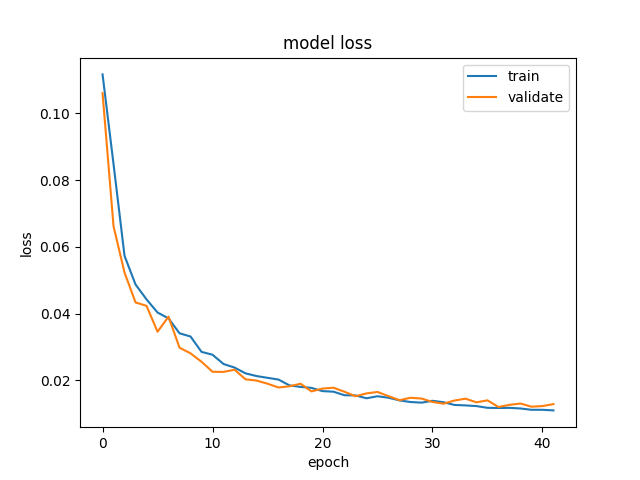

In [0]:
%cd /content/mycar/models
file = glob.glob("*.png")
Image(file[0])

## Plot commands and predictions
You can use 


```
donkey tubplot <tub_path> [--model=<model_path>]
```

to plot the commands and predictions of steering and throttle



/content/mycar
using donkey v3.1.1 ...
loading config file: ./config.py
loading personal config over-rides

config loaded
"get_model_by_type" model Type is: linear
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
2020-03-05 13:26:25.992189: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-03-05 13:26:26.004475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-03-05 13:26:26.005067: I tensorflow

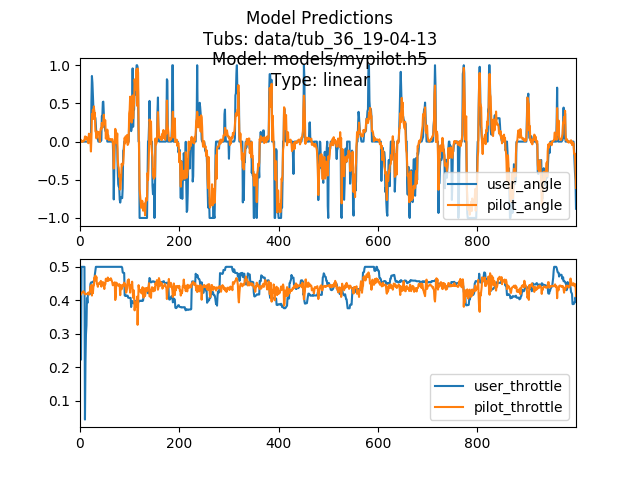

In [0]:
%cd /content/mycar
!donkey tubplot  --tub=data/ --tub=data/tub_36_19-04-13 --model=models/mypilot.h5 
file = glob.glob("/content/mycar/models/mypilot.h5_pred.png")
Image(file[0])

## Copy the trained model back to Donkey Car (Pi)

Once the training is complete on Colab, download


*   mypilot.h5 file from /content/mycar/models/ 
*   myconfig.py file from /content/mycar/

---




In [0]:
files.download('./mypilot.h5')
%cd /content/mycar
files.download('myconfig.py')

/content/mycar


Alternatively, you can copy the model back to Google Drive too

In [0]:
!cp /content/mycar/models/mypilot.h5 /content/drive/My\ Drive/myCar/mypilot.h5

## Copy the file from your PC or Mac to the Raspberry Pi using Filezilla or scp command.

```
sftp pi@raspberry.local
cd mycar/models
put mypilot.h5
```

## Start Autopilot on Pi


```bash
cd ~/mycar
python manage.py drive --model models/mypilot.h5 --js
```


# Step 6: Bonus - Salient Object Visualization
The salient visualization gives an indication which parts of the image caused the highest activations in the model. Its a good method to understand what triggers the steering and indentify problems
- reflections
- distractions off the track

> Note: It seems like the salient mode doesn't work for RNN networks

In [0]:
# !pip install git+https://github.com/autorope/keras-vis.git
!pip uninstall keras-vis
!pip install git+https://github.com/sctse999/keras-vis
  
  

Uninstalling keras-vis-0.4.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras_vis-0.4.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/vis/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/structure.py
Proceed (y/n)? y
  Successfully uninstalled keras-vis-0.4.1
  Cloning https://github.com/sctse999/keras-vis to /tmp/pip-req-build-fppmjn_o
  Running command git clone -q https://github.com/sctse999/keras-vis /tmp/pip-req-build-fppmjn_o
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38989 sha256=3425b80d2a4c02e113e49cc0eac6273520739475597a75c838d65a26dba7950b
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ih_t8yg/wheels/29/87/8e/abd2257f08391eabe7552711aecf08cbb50f79877210b21be0
Successfully built keras-vis


In [0]:
%cd /content/mycar
!donkey makemovie --tub data/{tub_name} --model models/mypilot.h5 --type linear --salient

Download the movie to local machine

In [0]:
%cd /content/mycar
!ls -ahl
files.download('tub_movie.mp4')

/content/mycar
total 89M
drwxr-xr-x 6 root root 4.0K Mar  2 11:48 .
drwxr-xr-x 1 root root 4.0K Mar  2 10:52 ..
-rw-r--r-- 1 root root  13K Mar  2 10:51 config.py
drwxr-xr-x 3 root root 4.0K Mar  2 10:52 data
drwxr-xr-x 2 root root 4.0K Mar  2 10:51 logs
-rw-r--r-- 1 root root  23K Mar  2 10:51 manage.py
drwxr-xr-x 2 root root 4.0K Mar  2 11:35 models
-rw-r--r-- 1 root root  14K Mar  2 10:52 myconfig.py
-rw-r--r-- 1 root root 1.8M Mar  2 11:46 mypilot.h5
drwxr-xr-x 2 root root 4.0K Mar  2 10:54 __pycache__
-rw-r--r-- 1 root root  39K Mar  2 10:51 train.py
-rw-r--r-- 1 root root  39M Mar  2 11:50 tub_movie.mp4
-rw------- 1 root root  49M Mar  2 11:46 tubVaihingenIIICleaned200126.tar.gz


Or download the file to Google Drive

In [0]:
!cp /content/mycar/tub_movie.mp4 /content/drive/My\ Drive/myCar/tub_movie.mp4